In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess the data
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

# Separate features and labels
X = data.iloc[:, 1:].values  # pixel values
Y = data.iloc[:, 0].values   # labels (0-9)

# Normalize pixel values to be between 0 and 1
X = X / 255.0

# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)

# Split into training and development sets
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create DataLoader for batching
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

dev_data = TensorDataset(X_dev, Y_dev)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

In [2]:
# Shallow Neural Network 
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=15, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=15, out_channels=15, kernel_size=3, stride=2)
        # Digit pictures dimensions 28*28
        # After Layer 1 : dimension = (28-3)/2 + 1 = 13
        # After Layer 2 : dimension = (13-3)/2 + 1 = 6
        # After Layer 3 : dimension = (6-3)/2 + 1 =~ 2
        self.fc1 = nn.Linear(15 * 2 * 2, 10)

    def forward(self, x):
        x = x.view(x.size(0), 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))      
        # Flatten and apply the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

# Training function with tracking loss per epoch and accuracy on dev set
def train_model(model, criterion, optimizer, train_loader, dev_loader, epochs=10):
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        # Evaluate on the dev set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Dev Accuracy: {accuracy:.2f}%')
    
    return model, losses, accuracies

Training SNN...
Epoch [1/10], Loss: 0.6896, Dev Accuracy: 88.75%
Epoch [2/10], Loss: 0.3403, Dev Accuracy: 90.42%
Epoch [3/10], Loss: 0.3034, Dev Accuracy: 91.26%
Epoch [4/10], Loss: 0.2832, Dev Accuracy: 91.12%
Epoch [5/10], Loss: 0.2700, Dev Accuracy: 91.70%
Epoch [6/10], Loss: 0.2599, Dev Accuracy: 91.86%
Epoch [7/10], Loss: 0.2527, Dev Accuracy: 91.95%
Epoch [8/10], Loss: 0.2458, Dev Accuracy: 91.86%
Epoch [9/10], Loss: 0.2408, Dev Accuracy: 91.93%
Epoch [10/10], Loss: 0.2357, Dev Accuracy: 92.01%
Training CNN...
Epoch [1/10], Loss: 0.5435, Dev Accuracy: 91.51%
Epoch [2/10], Loss: 0.2083, Dev Accuracy: 94.65%
Epoch [3/10], Loss: 0.1553, Dev Accuracy: 95.49%
Epoch [4/10], Loss: 0.1299, Dev Accuracy: 96.10%
Epoch [5/10], Loss: 0.1135, Dev Accuracy: 96.32%
Epoch [6/10], Loss: 0.1024, Dev Accuracy: 96.50%
Epoch [7/10], Loss: 0.0929, Dev Accuracy: 97.02%
Epoch [8/10], Loss: 0.0871, Dev Accuracy: 97.21%
Epoch [9/10], Loss: 0.0801, Dev Accuracy: 96.96%
Epoch [10/10], Loss: 0.0747, Dev Acc

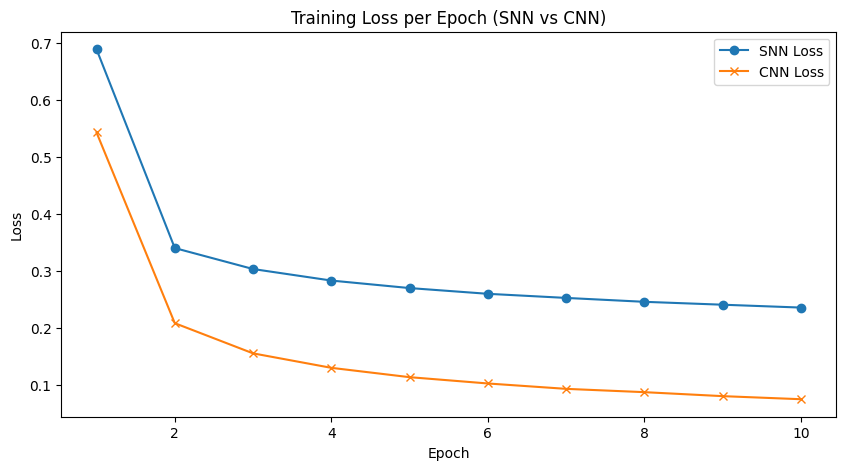

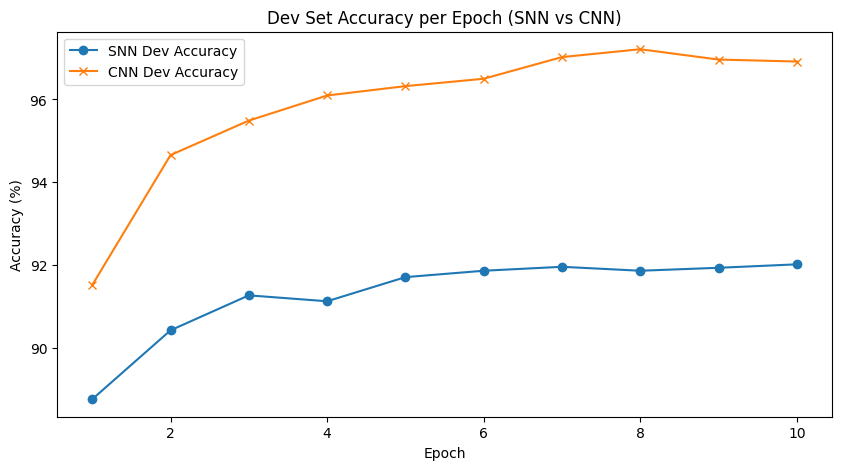

Final SNN Dev Accuracy: 92.01%
Final CNN Dev Accuracy: 96.92%


In [3]:
# Initialize both models
snn_model = SNN()
cnn_model = CNN()

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
snn_optimizer = optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the SNN model and track both losses and dev accuracies
print("Training SNN...")
snn_model, snn_losses, snn_accuracies = train_model(snn_model, criterion, snn_optimizer, train_loader, dev_loader, epochs=10)

# Train the CNN model and track both losses and dev accuracies
print("Training CNN...")
cnn_model, cnn_losses, cnn_accuracies = train_model(cnn_model, criterion, cnn_optimizer, train_loader, dev_loader, epochs=10)

# Plotting training loss comparison between SNN and CNN
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), snn_losses, label="SNN Loss", marker='o')
plt.plot(range(1, 11), cnn_losses, label="CNN Loss", marker='x')
plt.title("Training Loss per Epoch (SNN vs CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting development accuracy comparison between SNN and CNN
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), snn_accuracies, label="SNN Dev Accuracy", marker='o')
plt.plot(range(1, 11), cnn_accuracies, label="CNN Dev Accuracy", marker='x')
plt.title("Dev Set Accuracy per Epoch (SNN vs CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# Evaluation function to compare accuracies (this could be for the test set or dev set)
def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Evaluate both models on the dev set
snn_dev_accuracy = evaluate_model(snn_model, dev_loader)
cnn_dev_accuracy = evaluate_model(cnn_model, dev_loader)

# Print final dev accuracy results
print(f'Final SNN Dev Accuracy: {snn_dev_accuracy:.2f}%')
print(f'Final CNN Dev Accuracy: {cnn_dev_accuracy:.2f}%')